In [1]:
import xarray as xr
from dask.distributed import Client
from dask_ml.cluster import KMeans
# import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:42763 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 50.56 GB


In [3]:
ds = xr.open_dataset('era5_79_20_decades.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:          (expver: 2, latitude: 129, longitude: 173, time: 6)
Coordinates:
  * expver           (expver) int32 1 5
  * longitude        (longitude) float32 -18.5 -18.25 -18.0 ... 24.0 24.25 24.5
  * latitude         (latitude) float32 23.5 23.25 23.0 ... -8.0 -8.25 -8.5
  * time             (time) int64 1970 1980 1990 2000 2010 2020
Data variables:
    annual_max_t2m   (time, expver, latitude, longitude) float32 ...
    annual_max_tp    (time, expver, latitude, longitude) float32 ...
    annual_mean_t2m  (time, expver, latitude, longitude) float32 ...
    annual_mean_tp   (time, expver, latitude, longitude) float32 ...
    annual_min_t2m   (time, expver, latitude, longitude) float32 ...
    annual_min_tp    (time, expver, latitude, longitude) float32 ...
    sum_max_t2m      (time, expver, latitude, longitude) float32 ...
    sum_max_tp       (time, expver, latitude, longitude) float32 ...
    sum_mean_t2m     (time, expver, latitude, longitude) float32 ...
    sum_mean_tp      (time, expver, latitude, longitude) float32 ...
    sum_min_t2m      (time, expver, latitude, longitude) float32 ...
    sum_min_tp       (time, expver, latitude, longitude) float32 ...
    win_max_t2m      (time, expver, latitude, longitude) float32 ...
    win_max_tp       (time, expver, latitude, longitude) float32 ...
    win_mean_t2m     (time, expver, latitude, longitude) float32 ...
    win_mean_tp      (time, expver, latitude, longitude) float32 ...
    win_min_t2m      (time, expver, latitude, longitude) float32 ...
    win_min_tp       (time, expver, latitude, longitude) float32 ...

In [80]:
df = ds.to_dask_dataframe()
df = df[df.expver == 1]
t2m_cols = ['annual_max_t2m', 'annual_mean_t2m', 'annual_min_t2m', 'sum_max_t2m', 'sum_mean_t2m', 'sum_min_t2m','win_max_t2m', 'win_mean_t2m', 'win_min_t2m']
(df['win_max_t2m'] > 0).any().compute()

True

In [81]:
#convert to celcius fronm kelvin
for col in t2m_cols:
    df[col] = df[col] - 273.15

In [82]:
#dropping 1970s decade
df = df[df.time != 1970]

In [83]:
df.tail(6)

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp
133895,1,-8.5,24.25,2020,23.912628,0.009031,22.802185,0.005412,22.082153,1.862645e-09,...,22.324615,0.007545,22.082153,0.006054,23.912628,0.009031,23.279724,0.003278,22.638214,1.862645e-09
133897,1,-8.5,24.50,1980,24.317108,0.008935,22.352936,0.004163,20.861176,2.837367e-06,...,21.543182,0.007162,20.861176,0.005678,24.317108,0.004124,23.162689,0.001163,22.179596,2.837367e-06
133898,1,-8.5,24.50,1990,24.488983,0.008637,22.614594,0.004015,21.271942,1.784414e-06,...,21.760040,0.006893,21.271942,0.005162,24.488983,0.003792,23.469116,0.001137,22.415009,1.784414e-06
133899,1,-8.5,24.50,2000,24.983856,0.007993,22.805908,0.003630,21.241455,7.779524e-06,...,21.919067,0.006311,21.241455,0.004388,24.983856,0.003329,23.692719,0.000949,22.415009,7.779524e-06
133900,1,-8.5,24.50,2010,24.995270,0.008565,23.076813,0.003510,21.564911,1.862645e-09,...,22.277649,0.006122,21.564911,0.003943,24.995270,0.003661,23.875946,0.000898,22.589539,1.862645e-09
133901,1,-8.5,24.50,2020,23.836334,0.009094,22.714874,0.005322,21.949432,1.862645e-09,...,22.213226,0.008084,21.949432,0.006302,23.836334,0.007093,23.216492,0.002560,22.673157,1.862645e-09


In [84]:
df.expver.value_counts().compute()

1    111585
Name: expver, dtype: int64

In [85]:
df[df.expver == 5].head()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp


In [86]:
df[df.expver == 1].tail()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp
133897,1,-8.5,24.5,1980,24.317108,0.008935,22.352936,0.004163,20.861176,2.837367e-06,...,21.543182,0.007162,20.861176,0.005678,24.317108,0.004124,23.162689,0.001163,22.179596,2.837367e-06
133898,1,-8.5,24.5,1990,24.488983,0.008637,22.614594,0.004015,21.271942,1.784414e-06,...,21.760040,0.006893,21.271942,0.005162,24.488983,0.003792,23.469116,0.001137,22.415009,1.784414e-06
133899,1,-8.5,24.5,2000,24.983856,0.007993,22.805908,0.003630,21.241455,7.779524e-06,...,21.919067,0.006311,21.241455,0.004388,24.983856,0.003329,23.692719,0.000949,22.415009,7.779524e-06
133900,1,-8.5,24.5,2010,24.995270,0.008565,23.076813,0.003510,21.564911,1.862645e-09,...,22.277649,0.006122,21.564911,0.003943,24.995270,0.003661,23.875946,0.000898,22.589539,1.862645e-09
133901,1,-8.5,24.5,2020,23.836334,0.009094,22.714874,0.005322,21.949432,1.862645e-09,...,22.213226,0.008084,21.949432,0.006302,23.836334,0.007093,23.216492,0.002560,22.673157,1.862645e-09


In [87]:
df.time.value_counts().compute()

2020    22317
2010    22317
2000    22317
1990    22317
1980    22317
Name: time, dtype: int64

In [88]:
df[df.time == 2020].isnull().any().compute()

expver             False
latitude           False
longitude          False
time               False
annual_max_t2m     False
annual_max_tp      False
annual_mean_t2m    False
annual_mean_tp     False
annual_min_t2m     False
annual_min_tp      False
sum_max_t2m        False
sum_max_tp         False
sum_mean_t2m       False
sum_mean_tp        False
sum_min_t2m        False
sum_min_tp         False
win_max_t2m        False
win_max_tp         False
win_mean_t2m       False
win_mean_tp        False
win_min_t2m        False
win_min_tp         False
dtype: bool

In [89]:
#I think I need to drop 2020, 
#even though I'd like to keep it, my features need winter months,
#and I'd probably see a bias if I clustered with a partial year

In [90]:
# df = df[df.time != 2020]

In [91]:
X = df.drop(['latitude', 'longitude', 'time', 'expver'], axis=1)
X.head()

,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,sum_max_t2m,sum_max_tp,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp
1,23.121857,0.000457,20.658691,0.000104,18.350739,0.000006,23.121857,0.000149,21.292938,0.000044,19.254974,0.000006,22.580536,0.000457,20.024475,0.000164,18.350739,0.000032
2,23.264008,0.000624,20.920990,0.000110,18.687561,0.000005,23.264008,0.000164,21.489868,0.000042,19.335541,0.000006,22.744293,0.000623,20.352234,0.000178,18.687561,0.000020
3,23.561035,0.000780,21.006836,0.000113,18.695404,0.000007,23.481049,0.000079,21.622040,0.000030,19.551086,0.000007,23.065369,0.000780,20.391693,0.000196,18.695404,0.000023
4,23.568298,0.000638,21.051727,0.000108,18.530212,0.000006,23.449402,0.000268,21.690277,0.000069,19.525848,0.000007,23.337036,0.000509,20.413147,0.000146,18.530212,0.000011
5,22.417419,0.000080,20.038818,0.000027,18.699524,0.000004,22.417419,0.000080,21.197632,0.000039,20.050201,0.000007,19.227112,0.000022,18.880035,0.000016,18.699524,0.000004


In [92]:
X.isnull().any().compute()

annual_max_t2m     False
annual_max_tp      False
annual_mean_t2m    False
annual_mean_tp     False
annual_min_t2m     False
annual_min_tp      False
sum_max_t2m        False
sum_max_tp         False
sum_mean_t2m       False
sum_mean_tp        False
sum_min_t2m        False
sum_min_tp         False
win_max_t2m        False
win_max_tp         False
win_mean_t2m       False
win_mean_tp        False
win_min_t2m        False
win_min_tp         False
dtype: bool

In [18]:
#using elbow method to find optimal clusters:
distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df)
    distortions.append(km.inertia_)

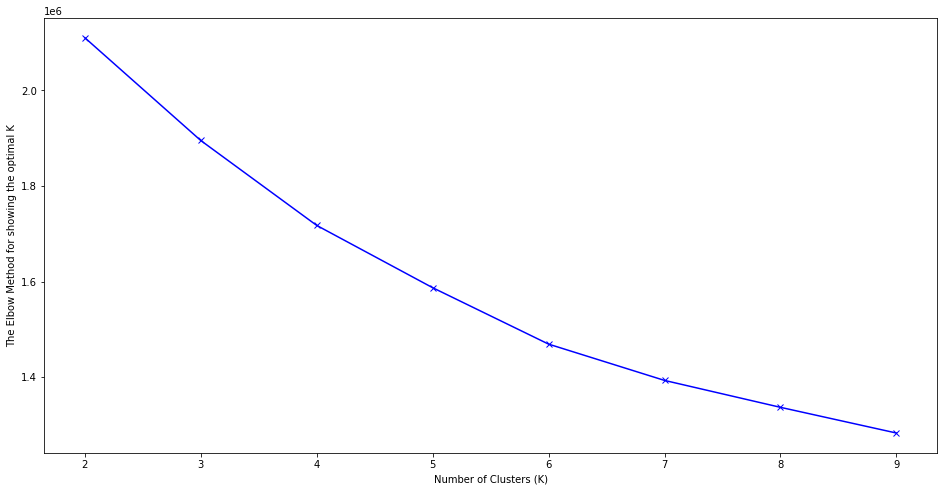

In [19]:
#plotting distortions
plt.figure(figsize=(16, 8))
plt.plot(K[1:], distortions[1:], 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('The Elbow Method for showing the optimal K')
plt.show()

In [94]:
#let's tak ea look at 5 major zones
km = KMeans(n_clusters = 10)
km.fit(X)
labels = km.predict(X)
labels
df['clust'] = labels
clusters = df.groupby('clust')


In [21]:
df.head()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp,clust
1,1,23.5,-18.5,1980,23.121857,0.000457,20.658691,0.000104,18.350739,0.000006,...,0.000044,19.254974,0.000006,22.580536,0.000457,20.024475,0.000164,18.350739,0.000032,1
2,1,23.5,-18.5,1990,23.264008,0.000624,20.920990,0.000110,18.687561,0.000005,...,0.000042,19.335541,0.000006,22.744293,0.000623,20.352234,0.000178,18.687561,0.000020,1
3,1,23.5,-18.5,2000,23.561035,0.000780,21.006836,0.000113,18.695404,0.000007,...,0.000030,19.551086,0.000007,23.065369,0.000780,20.391693,0.000196,18.695404,0.000023,1
4,1,23.5,-18.5,2010,23.568298,0.000638,21.051727,0.000108,18.530212,0.000006,...,0.000069,19.525848,0.000007,23.337036,0.000509,20.413147,0.000146,18.530212,0.000011,1
5,1,23.5,-18.5,2020,22.417419,0.000080,20.038818,0.000027,18.699524,0.000004,...,0.000039,20.050201,0.000007,19.227112,0.000022,18.880035,0.000016,18.699524,0.000004,1


<ipython-input-22-f836dada838f>:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
<ipython-input-22-f836dada838f>:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries()


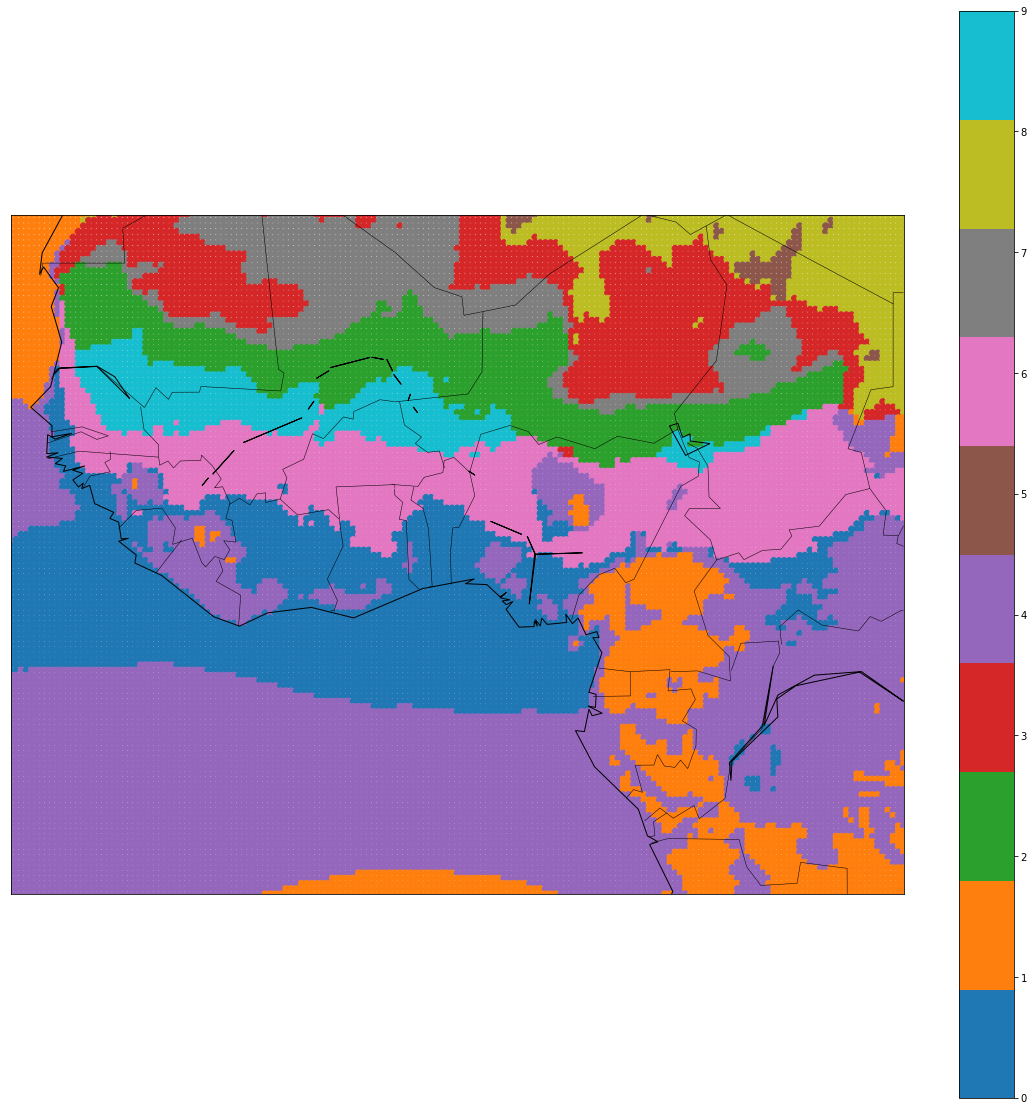

In [22]:
plt.figure(figsize=(20,20))
# ll_lon, ur_lon, ll_lat, ur_lat 
m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
year = df[df.time == 1980]
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
lons = year.longitude.to_dask_array(lengths=True).compute()
lats = year.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=year.clust, cmap='tab10')
m.drawcountries()
m.drawcoastlines()

plt.colorbar()
plt.show()

<ipython-input-23-c35ff74f6ee5>:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
<ipython-input-23-c35ff74f6ee5>:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=1, zorder=2)


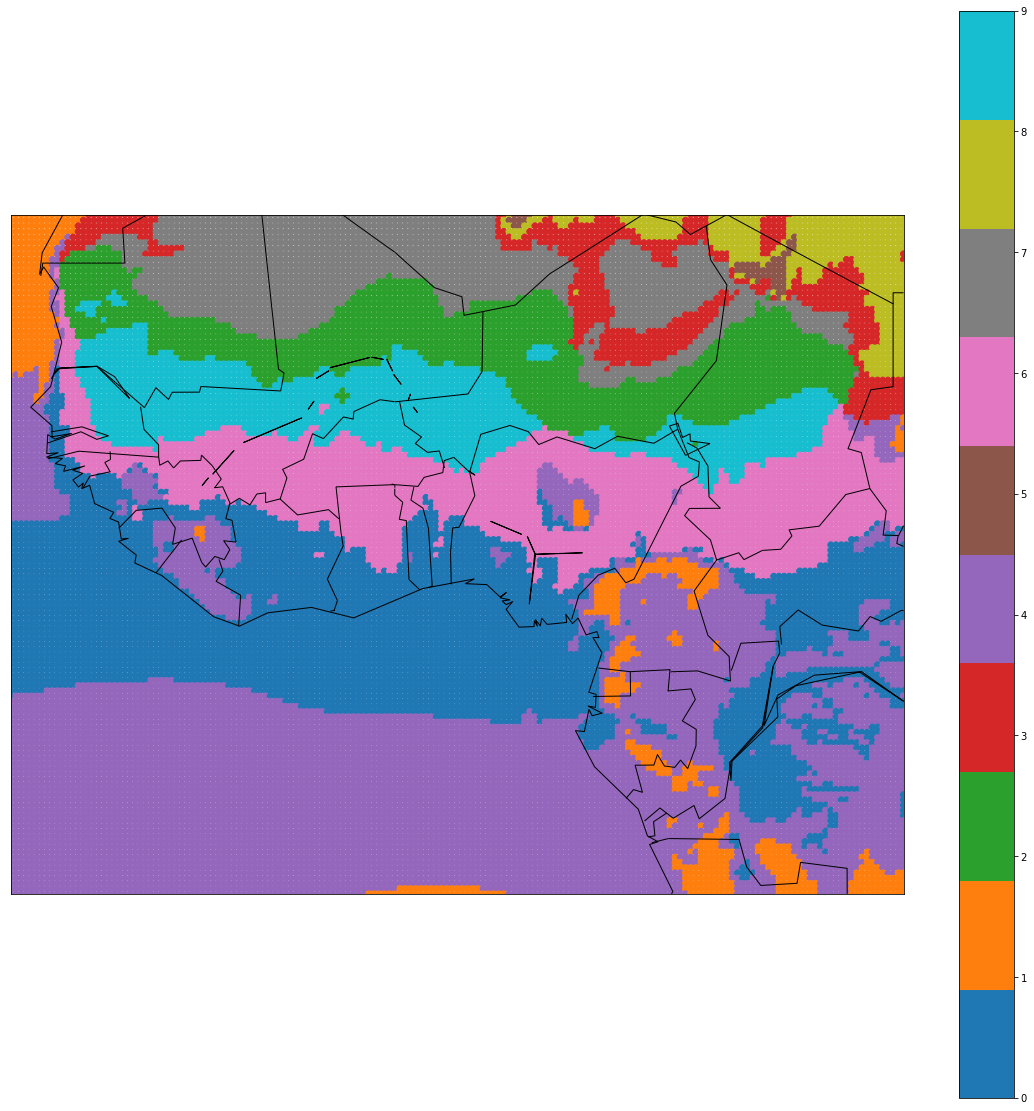

In [23]:
plt.figure(figsize=(20,20))
# ll_lon, ur_lon, ll_lat, ur_lat 
m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)

year = df[df.time == 2010]

lons = year.longitude.to_dask_array(lengths=True).compute()
lats = year.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=year.clust, cmap='tab10', zorder=1)
m.drawcountries(linewidth=1, zorder=2)
m.drawcoastlines()

plt.colorbar()
plt.show()

In [24]:
means = df.groupby('clust').mean()

In [25]:
means.sum_max_tp.compute()

clust
0    0.008593
1    0.006350
2    0.001246
3    0.000414
4    0.005824
5    0.000522
6    0.007364
7    0.000257
8    0.000171
9    0.003109
Name: sum_max_tp, dtype: float64

In [26]:
means.sum_mean_t2m.compute()

clust
0    26.302289
1    22.840411
2    32.862713
3    31.119505
4    25.123109
5    25.339522
6    28.340307
7    33.080460
8    29.173089
9    32.375616
Name: sum_mean_t2m, dtype: float64

In [27]:
means.sum_mean_tp.compute()

clust
0    0.005141
1    0.004666
2    0.000405
3    0.000115
4    0.003506
5    0.000144
6    0.003825
7    0.000072
8    0.000043
9    0.001178
Name: sum_mean_tp, dtype: float64

In [36]:
means.sum_max_t2m.compute()

clust
0    27.526723
1    24.392360
2    34.780332
3    33.474291
4    26.614954
5    27.405894
6    31.838375
7    35.678357
8    31.509788
9    34.814706
Name: sum_max_t2m, dtype: float64

In [28]:
#6-1 cluster movement shows drought and heating effects
#9-1 cluster moverment shows drought effects
#5 is the 3rd highest heat region and is growing
#I could take pairwise differences of variables of each of the clusters, then order the cluster movement by increasing severity,
#then I'll have a map of areas with low, medium, and high risk of each type of cluster movement

In [48]:
clusters = df[df.time == 1980].groupby('clust')
clusters.clust.value_counts().compute().values #this gives a relative size of each cluster!

array([3571, 1901, 1608, 1664, 7786,   99, 2409, 1373,  968,  938])

In [46]:
clusters = df[df.time == 1990].groupby('clust')
clusters.clust.value_counts().compute() #this gives a relative size of each clus

clust  clust
0      0        3836
1      1        1614
2      2        1695
3      3        1423
4      4        7767
5      5          79
6      6        2563
7      7        1420
8      8         840
9      9        1080
Name: clust, dtype: int64

In [47]:
clusters = df[df.time == 2000].groupby('clust')
clusters.clust.value_counts().compute() #this gives a relative size of each clus

clust  clust
0      0        4033
1      1        1224
2      2        1840
3      3        1180
4      4        7752
5      5          68
6      6        2556
7      7        1561
8      8         734
9      9        1369
Name: clust, dtype: int64

In [30]:
clusters = df[df.time == 2010].groupby('clust')
clusters.clust.value_counts().compute() #this gives a relative size of each cluster!

clust  clust
0      0        4788
1      1         840
2      2        1834
3      3         815
4      4        7220
5      5          57
6      6        2609
7      7        1859
8      8         560
9      9        1735
Name: clust, dtype: int64

In [50]:
from collections import defaultdict

clust_sizes = defaultdict(list)

for decade in [1980, 1990, 2000, 2010]:
    clusters = df[df.time == decade].groupby('clust')
     #this gives a relative size of each clus
    for ix, value in enumerate(clusters.clust.value_counts().compute().values):
        clust_sizes[ix].append(value)
    

In [51]:
clust_sizes

defaultdict(list,
            {0: [3571, 3836, 4033, 4788],
             1: [1901, 1614, 1224, 840],
             2: [1608, 1695, 1840, 1834],
             3: [1664, 1423, 1180, 815],
             4: [7786, 7767, 7752, 7220],
             5: [99, 79, 68, 57],
             6: [2409, 2563, 2556, 2609],
             7: [1373, 1420, 1561, 1859],
             8: [968, 840, 734, 560],
             9: [938, 1080, 1369, 1735]})

Text(0, 0.5, 'Relative Size')

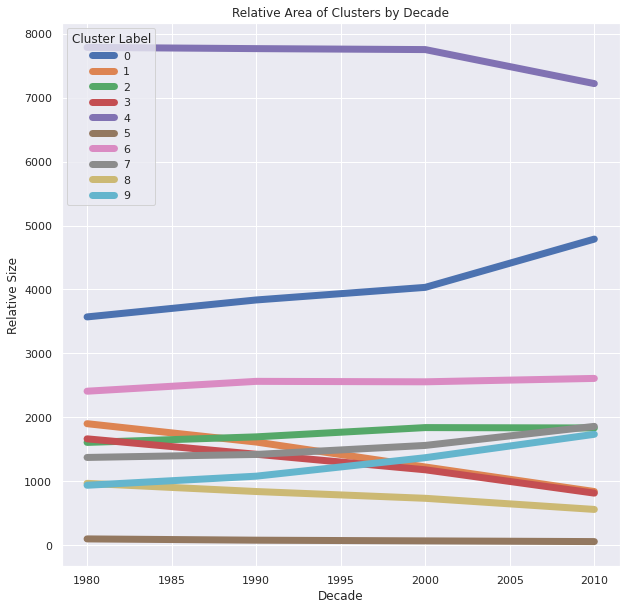

In [76]:
import seaborn as sns
import pandas as pd
plt.figure(figsize=(10, 10))
for clust, values in clust_sizes.items():
    plt.plot([1980, 1990, 2000, 2010], values, label=clust, linewidth=7)
    
plt.legend(loc='upper left', title='Cluster Label')
plt.title('Relative Area of Clusters by Decade')
plt.xlabel('Decade')
plt.ylabel('Relative Size')

In [58]:
clust_size_df

,0,1,2,3,4,5,6,7,8,9
0,3571,1901,1608,1664,7786,99,2409,1373,968,938
1,3836,1614,1695,1423,7767,79,2563,1420,840,1080
2,4033,1224,1840,1180,7752,68,2556,1561,734,1369
3,4788,840,1834,815,7220,57,2609,1859,560,1735


In [78]:
means.sum_mean_tp.compute().sort_values()

clust
8    0.000043
7    0.000072
3    0.000115
5    0.000144
2    0.000405
9    0.001178
4    0.003506
6    0.003825
1    0.004666
0    0.005141
Name: sum_mean_tp, dtype: float64

In [95]:
df.head()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp,clust
1,1,23.5,-18.5,1980,23.121857,0.000457,20.658691,0.000104,18.350739,0.000006,...,0.000044,19.254974,0.000006,22.580536,0.000457,20.024475,0.000164,18.350739,0.000032,3
2,1,23.5,-18.5,1990,23.264008,0.000624,20.920990,0.000110,18.687561,0.000005,...,0.000042,19.335541,0.000006,22.744293,0.000623,20.352234,0.000178,18.687561,0.000020,3
3,1,23.5,-18.5,2000,23.561035,0.000780,21.006836,0.000113,18.695404,0.000007,...,0.000030,19.551086,0.000007,23.065369,0.000780,20.391693,0.000196,18.695404,0.000023,3
4,1,23.5,-18.5,2010,23.568298,0.000638,21.051727,0.000108,18.530212,0.000006,...,0.000069,19.525848,0.000007,23.337036,0.000509,20.413147,0.000146,18.530212,0.000011,3
5,1,23.5,-18.5,2020,22.417419,0.000080,20.038818,0.000027,18.699524,0.000004,...,0.000039,20.050201,0.000007,19.227112,0.000022,18.880035,0.000016,18.699524,0.000004,3


In [228]:
df =df[df.time != 2020]
df.head()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp,clust
1,1,23.5,-18.50,1980,23.121857,0.000457,20.658691,0.000104,18.350739,0.000006,...,0.000044,19.254974,0.000006,22.580536,0.000457,20.024475,0.000164,18.350739,0.000032,3
2,1,23.5,-18.50,1990,23.264008,0.000624,20.920990,0.000110,18.687561,0.000005,...,0.000042,19.335541,0.000006,22.744293,0.000623,20.352234,0.000178,18.687561,0.000020,3
3,1,23.5,-18.50,2000,23.561035,0.000780,21.006836,0.000113,18.695404,0.000007,...,0.000030,19.551086,0.000007,23.065369,0.000780,20.391693,0.000196,18.695404,0.000023,3
4,1,23.5,-18.50,2010,23.568298,0.000638,21.051727,0.000108,18.530212,0.000006,...,0.000069,19.525848,0.000007,23.337036,0.000509,20.413147,0.000146,18.530212,0.000011,3
7,1,23.5,-18.25,1980,22.984772,0.000464,20.558838,0.000100,18.289886,0.000005,...,0.000040,19.178619,0.000006,22.471069,0.000464,19.945190,0.000160,18.289886,0.000028,3


In [229]:
#For each lat/lon, I want a list of the history of the cluster movement.
cluster_history = default_dict(list)
for decade in [1980, 1990, 2000, 2010]:
    dec_df = df[df.time == decade]
    

NameError: name 'default_dict' is not defined

In [230]:
dec_df = df[df.time == 1980]
test1 = dec_df.clust.compute().values

In [231]:
dec_df = df[df.time == 2010]
test2 = dec_df.clust.compute().values

In [232]:
test3 = [str(i) + str(j) for i, j in zip(test1, test2)]

In [233]:
def get_clust_history(x):
    return ''.join(map(str, x))

In [291]:
hist_df = df[(df.time == 2000) | (df.time == 2010)]
hist_df.head()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp,clust
3,1,23.5,-18.50,2000,23.561035,0.000780,21.006836,0.000113,18.695404,0.000007,...,0.000030,19.551086,0.000007,23.065369,0.000780,20.391693,0.000196,18.695404,0.000023,3
4,1,23.5,-18.50,2010,23.568298,0.000638,21.051727,0.000108,18.530212,0.000006,...,0.000069,19.525848,0.000007,23.337036,0.000509,20.413147,0.000146,18.530212,0.000011,3
9,1,23.5,-18.25,2000,23.420990,0.000754,20.894379,0.000111,18.620575,0.000008,...,0.000031,19.466309,0.000008,22.940674,0.000754,20.298645,0.000191,18.620575,0.000019,3
10,1,23.5,-18.25,2010,23.420990,0.000663,20.928162,0.000110,18.456390,0.000005,...,0.000074,19.460999,0.000006,23.204010,0.000510,20.297089,0.000146,18.456390,0.000009,3
15,1,23.5,-18.00,2000,23.315338,0.000646,20.800873,0.000101,18.531982,0.000005,...,0.000032,19.398438,0.000006,22.826263,0.000646,20.203461,0.000170,18.531982,0.000018,3


In [294]:
clust_hist_df = hist_df.groupby(['longitude', 'latitude'])['clust'].apply(lambda x: get_clust_history(x), meta=('history', 'f8')).compute()

In [295]:
clust_hist_df = clust_hist_df.reset_index()
clust_hist_df.head()

,longitude,latitude,history
0,-18.5,-8.50,11
1,-18.5,-8.25,11
2,-18.5,-8.00,11
3,-18.5,-7.75,11
4,-18.5,-7.50,11


In [296]:
clust_hist_df['history'] = clust_hist_df.history.astype(str)

In [297]:
clust_hist_df.history

0        11
1        11
2        11
3        11
4        11
         ..
22312    77
22313    77
22314    77
22315    77
22316    77
Name: history, Length: 22317, dtype: object

In [298]:
means.sum_max_tp.compute()

clust
0    0.008593
1    0.006350
2    0.001246
3    0.000414
4    0.005824
5    0.000522
6    0.007364
7    0.000257
8    0.000171
9    0.003109
Name: sum_max_tp, dtype: float64

In [299]:
from scipy.spatial.distance import pdist

In [300]:
pdist([list(means.sum_max_tp.compute().values), list(means.sum_max_tp.compute().values)])

array([0.])

In [301]:
means.sum_max_tp.compute().values(), means.sum_max_tp.compute().values)

SyntaxError: unmatched ')' (<ipython-input-301-b720a39025e8>, line 1)

In [302]:
list(means.sum_max_tp.compute().values)

[0.008593297203665667,
 0.006349697539071916,
 0.0012456793489427512,
 0.00041359435066738395,
 0.005824499001605097,
 0.0005216932597946613,
 0.007363940466173076,
 0.0002566590277028815,
 0.00017081219454095887,
 0.003108962200373719]

In [303]:
max_tp_df = means.sum_max_tp.compute().reset_index()
max_tp_df

,clust,sum_max_tp
0,0,0.008593
1,1,0.006350
2,2,0.001246
3,3,0.000414
4,4,0.005824
5,5,0.000522
6,6,0.007364
7,7,0.000257
8,8,0.000171
9,9,0.003109


In [304]:
tp_severity = defaultdict(int)
for clust1 in max_tp_df.clust:
    for clust2 in max_tp_df.clust:
        x1 = max_tp_df[max_tp_df.clust == clust1].sum_max_tp.values
        x2 = max_tp_df[max_tp_df.clust == clust2].sum_max_tp.values
        tp_severity[str(clust1) + str(clust2)] = (x2-x1)/x1

In [305]:
sort_severity = sorted(tp_severity.items(), key=lambda x: x[1], reverse=False)
sort_severity
#This marks the percent change in max total precipitation during the summer time for each cluster.
#now I need to find which cluster movements are actually present.
for i in sort_severity:
    print(i[0], i[1])

08 [-0.98012262]
68 [-0.97680424]
18 [-0.97309916]
48 [-0.9706735]
07 [-0.97013265]
67 [-0.96514651]
17 [-0.95957933]
47 [-0.95593457]
03 [-0.95187012]
98 [-0.94505813]
63 [-0.94383519]
05 [-0.93929068]
13 [-0.93486393]
65 [-0.92915569]
43 [-0.92899057]
15 [-0.91783967]
97 [-0.91744543]
45 [-0.91043122]
93 [-0.86696707]
28 [-0.86287627]
02 [-0.85504058]
95 [-0.83219698]
62 [-0.83084065]
12 [-0.80382068]
27 [-0.7939606]
42 [-0.78613107]
58 [-0.67258117]
23 [-0.66797687]
09 [-0.63821079]
92 [-0.59932631]
38 [-0.58700549]
25 [-0.58119779]
69 [-0.57781269]
19 [-0.51037633]
57 [-0.50802694]
49 [-0.46622667]
37 [-0.37944262]
78 [-0.33447814]
04 [-0.3222044]
01 [-0.26108717]
64 [-0.20905132]
53 [-0.20720779]
06 [-0.14305996]
61 [-0.13773101]
14 [-0.08271237]
00 [0.]
11 [0.]
22 [0.]
33 [0.]
44 [0.]
55 [0.]
66 [0.]
77 [0.]
88 [0.]
99 [0.]
41 [0.09017059]
16 [0.1597309]
60 [0.16694279]
35 [0.26136457]
46 [0.26430453]
10 [0.35333961]
40 [0.47537105]
87 [0.50258024]
73 [0.61145452]
94 [0.87345443]

In [306]:
clust_hist_df

,longitude,latitude,history
0,-18.5,-8.50,11
1,-18.5,-8.25,11
2,-18.5,-8.00,11
3,-18.5,-7.75,11
4,-18.5,-7.50,11
...,...,...,...
22312,24.5,22.50,77
22313,24.5,22.75,77
22314,24.5,23.00,77
22315,24.5,23.25,77


In [307]:
for i in sort_severity:
    check = clust_hist_df[clust_hist_df.history.str.contains('|'.join(i[0]))]
    if check is not None:
        break

In [308]:
check

,longitude,latitude,history
1150,-16.50,21.00,88
1151,-16.50,21.25,81
1272,-16.25,19.25,88
1273,-16.25,19.50,88
1274,-16.25,19.75,88
...,...,...,...
22268,24.50,11.50,00
22269,24.50,11.75,00
22270,24.50,12.00,00
22271,24.50,12.25,88


In [417]:
severe_clust_movements = []
for i in sort_severity:
    check = clust_hist_df[clust_hist_df.history.str.contains('|'.join(i[0]))]
    if check is not None:
        severe_clust_movements.append(i[0])
        if len(severe_clust_movements) > 20: #44
            break

In [418]:
severe_clust_movements

['08',
 '68',
 '18',
 '48',
 '07',
 '67',
 '17',
 '47',
 '03',
 '98',
 '63',
 '05',
 '13',
 '65',
 '43',
 '15',
 '97',
 '45',
 '93',
 '28',
 '02']

In [419]:
severity_dict = {}
for i in sort_severity:
    if i[0] in severe_clust_movements:
        severity_dict[i[0]] = i[1][0]

In [420]:
severity_dict

{'08': -0.9801226245883716,
 '68': -0.9768042401584315,
 '18': -0.9730991604734097,
 '48': -0.9706734957815449,
 '07': -0.9701326485492208,
 '67': -0.965146509687053,
 '17': -0.9595793301769779,
 '47': -0.9559345743501454,
 '03': -0.9518701214603684,
 '98': -0.9450581308063423,
 '63': -0.9438351854462612,
 '05': -0.939290676508649,
 '13': -0.9348639288529268,
 '65': -0.9291556929077432,
 '43': -0.9289905705961308,
 '15': -0.9178396677031465,
 '97': -0.9174454331828064,
 '45': -0.9104312216980559,
 '93': -0.8669670700346029,
 '28': -0.8628762733476053,
 '02': -0.8550405834431773}

In [421]:
clust_hist_df

,longitude,latitude,history,tp_severity
0,-18.5,-8.50,11,NaN
1,-18.5,-8.25,11,NaN
2,-18.5,-8.00,11,NaN
3,-18.5,-7.75,11,NaN
4,-18.5,-7.50,11,NaN
...,...,...,...,...
22312,24.5,22.50,77,NaN
22313,24.5,22.75,77,NaN
22314,24.5,23.00,77,NaN
22315,24.5,23.25,77,NaN


In [422]:
clust_hist_df['tp_severity'] = clust_hist_df.history.map(severity_dict)

In [423]:
# clust_hist_df['tp_severity'] = clust_hist_df['tp_severity'].fillna(0)
clust_hist_df

,longitude,latitude,history,tp_severity
0,-18.5,-8.50,11,NaN
1,-18.5,-8.25,11,NaN
2,-18.5,-8.00,11,NaN
3,-18.5,-7.75,11,NaN
4,-18.5,-7.50,11,NaN
...,...,...,...,...
22312,24.5,22.50,77,NaN
22313,24.5,22.75,77,NaN
22314,24.5,23.00,77,NaN
22315,24.5,23.25,77,NaN


In [424]:
non_null_history_df = clust_hist_df[clust_hist_df.tp_severity.notna()]
non_null_history_df.isnull.any()

AttributeError: 'function' object has no attribute 'any'

<ipython-input-458-8ed33f772cc2>:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
<ipython-input-458-8ed33f772cc2>:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.readshapefile('shapefiles/ni', 'ni')
<ipython-input-458-8ed33f772cc2>:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=1, zorder=2)


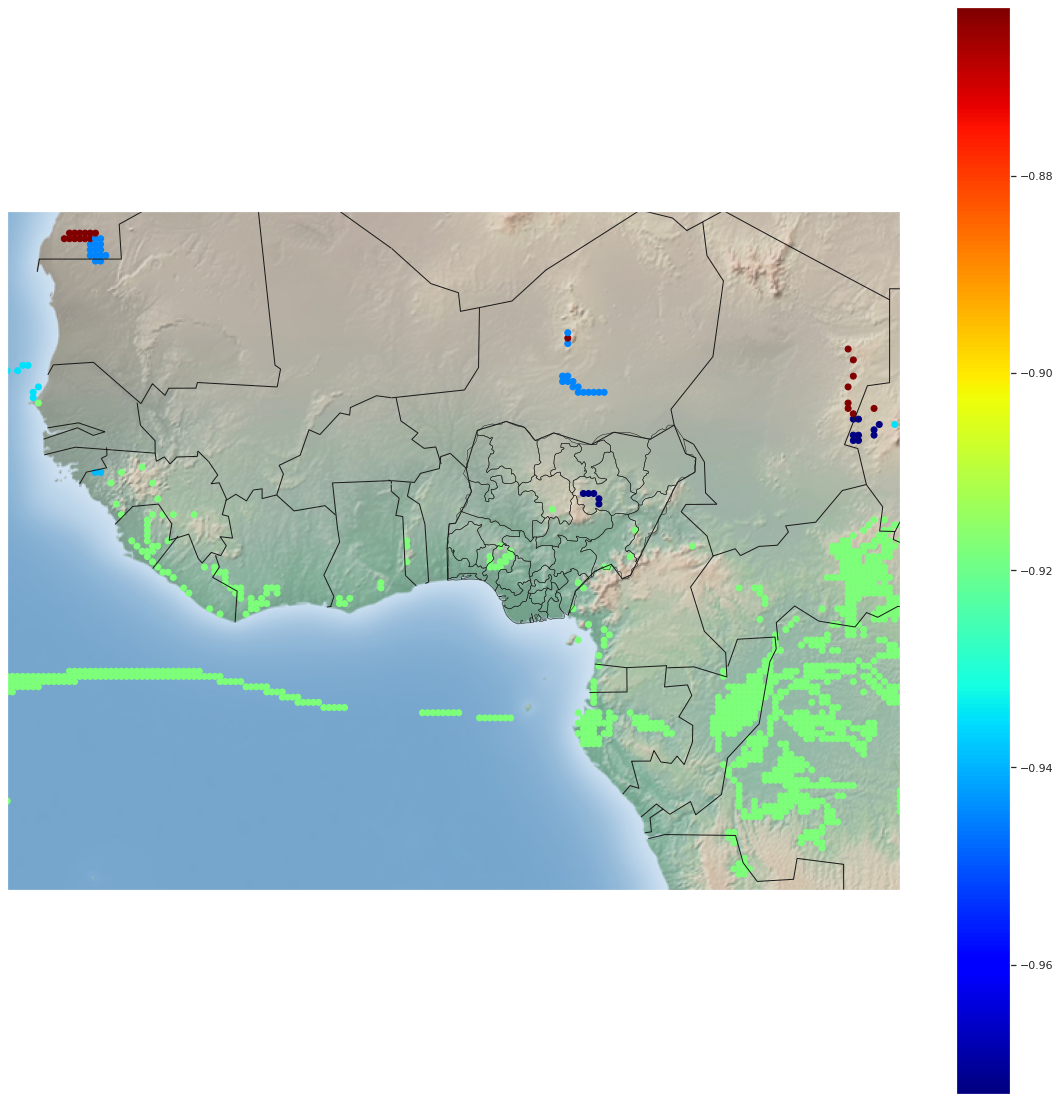

In [458]:
plt.figure(figsize=(20,20))
# ll_lon, ur_lon, ll_lat, ur_lat 
m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)


lons = clust_hist_df.longitude.values
lats = clust_hist_df.latitude.values
x, y = m(lons, lats) #transform coords
m.shadedrelief(scale=0.5)
# m.pcolormesh(x, y, clust_hist_df.tp_severity.values)
plt.scatter(x, y, c=clust_hist_df.tp_severity.values, zorder=1, cmap='jet')
m.readshapefile('shapefiles/ni', 'ni')

m.drawcountries(linewidth=1, zorder=2)
# m.drawcoastlines()

plt.colorbar()
plt.show()

In [440]:
#now let's do the same thing for temperature
max_t2m_df = means.sum_max_t2m.compute().reset_index()

t2m_severity = defaultdict(int)
for clust1 in max_t2m_df.clust:
    for clust2 in max_t2m_df.clust:
        x1 = max_t2m_df[max_t2m_df.clust == clust1].sum_max_t2m.values
        x2 = max_t2m_df[max_t2m_df.clust == clust2].sum_max_t2m.values
        t2m_severity[str(clust1) + str(clust2)] = (x2-x1)/x1
        
sort_severity = sorted(t2m_severity.items(), key=lambda x: x[1], reverse=True)

#This marks the percent change in max two meter temperature during the summer time for each cluster.
#now I need to find which cluster movements are actually present.



In [441]:
sort_severity

[('17', array([0.46268571])),
 ('19', array([0.42727912])),
 ('12', array([0.42586989])),
 ('13', array([0.37232685])),
 ('47', array([0.34053799])),
 ('49', array([0.30808817])),
 ('42', array([0.30679662])),
 ('16', array([0.30526014])),
 ('57', array([0.30184975])),
 ('07', array([0.29613529])),
 ('18', array([0.29178922])),
 ('59', array([0.27033645])),
 ('52', array([0.26908217])),
 ('09', array([0.26476031])),
 ('02', array([0.26351154])),
 ('43', array([0.25772492])),
 ('53', array([0.22142669])),
 ('03', array([0.21606524])),
 ('46', array([0.1962589])),
 ('48', array([0.18391292])),
 ('56', array([0.16173459])),
 ('06', array([0.15663516])),
 ('58', array([0.14974492])),
 ('08', array([0.14469812])),
 ('87', array([0.13229441])),
 ('10', array([0.12849772])),
 ('15', array([0.12354418])),
 ('67', array([0.12060858])),
 ('89', array([0.10488546])),
 ('82', array([0.10379454])),
 ('69', array([0.0934825])),
 ('62', array([0.09240284])),
 ('14', array([0.09111844])),
 ('37', arra

In [447]:
severe_clust_movements = []
for i in sort_severity:
    check = clust_hist_df[clust_hist_df.history.str.contains('|'.join(i[0]))]
    if check is not None:
        severe_clust_movements.append(i[0])
        if len(severe_clust_movements) > 30: #44
            break

In [448]:
severe_clust_movements

['17',
 '19',
 '12',
 '13',
 '47',
 '49',
 '42',
 '16',
 '57',
 '07',
 '18',
 '59',
 '52',
 '09',
 '02',
 '43',
 '53',
 '03',
 '46',
 '48',
 '56',
 '06',
 '58',
 '08',
 '87',
 '10',
 '15',
 '67',
 '89',
 '82',
 '69']

In [449]:
severity_dict = {}
for i in sort_severity:
    if i[0] in severe_clust_movements:
        severity_dict[i[0]] = i[1][0]
clust_hist_df['t2m_severity'] = clust_hist_df.history.map(severity_dict)


<ipython-input-455-265cc1238832>:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
<ipython-input-455-265cc1238832>:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.readshapefile('shapefiles/ni', 'ni')
<ipython-input-455-265cc1238832>:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=2, zorder=2)


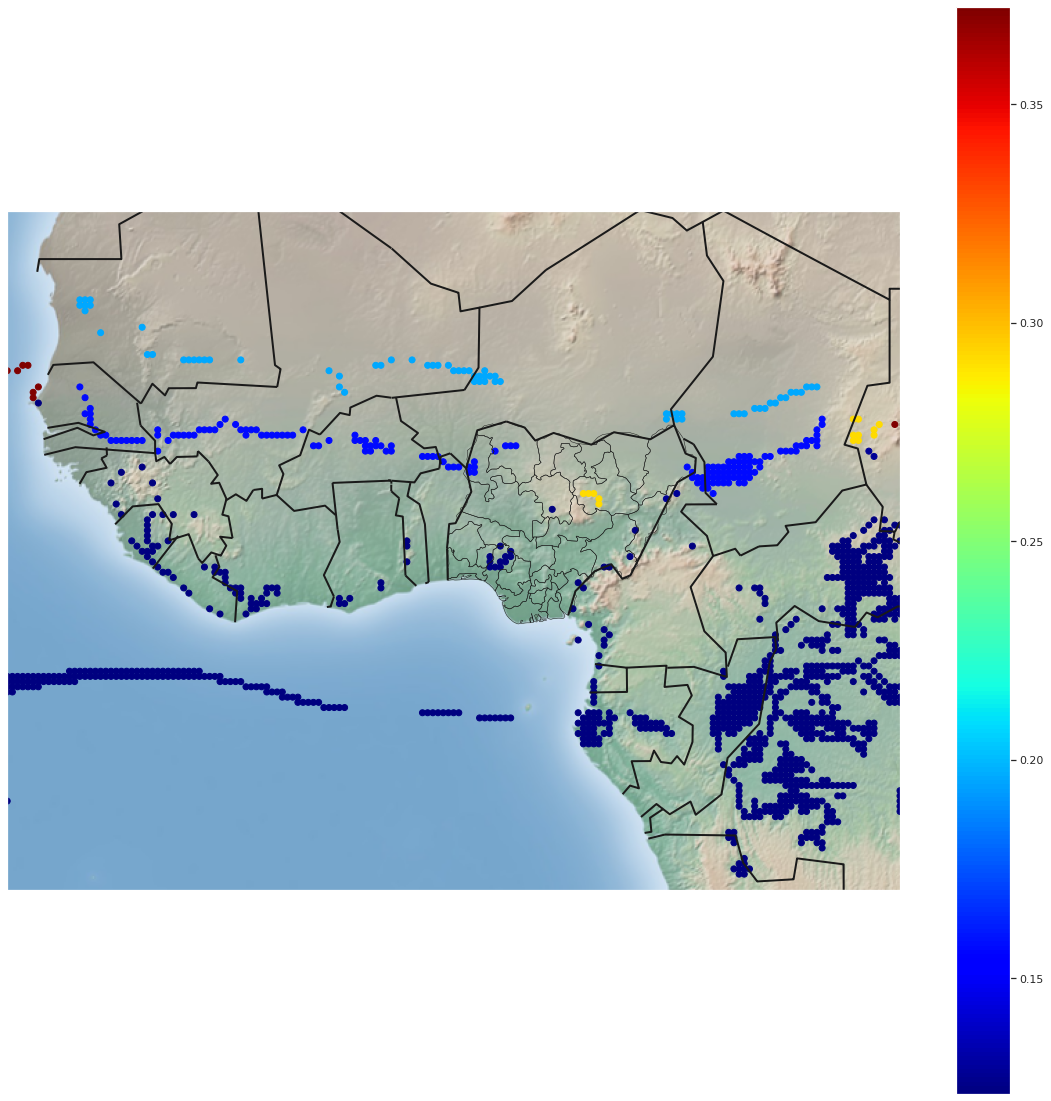

In [455]:
plt.figure(figsize=(20,20))
# ll_lon, ur_lon, ll_lat, ur_lat 
m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)


lons = clust_hist_df.longitude.values
lats = clust_hist_df.latitude.values
x, y = m(lons, lats) #transform coords
m.shadedrelief(scale=0.5)
# m.pcolormesh(x, y, clust_hist_df.tp_severity.values)
plt.scatter(x, y, c=clust_hist_df.t2m_severity.values, zorder=1, cmap='jet')

m.readshapefile('shapefiles/ni', 'ni')
m.drawcountries(linewidth=2, zorder=2)
# m.drawcoastlines()

plt.colorbar()
plt.show()

In [459]:
#Bauchi state seems to be getting hit the hardest
#Ekkiti is also hit with less rainfall and more heat
#Followed by Sokoto and Kebbi (only with heat)
#Kaduna (large agriculture supplier) is getting hit with both less rainfall and high heat
#My recommendation would be to start with addressing farmers in Kaduna

In [446]:
clust_hist_df

,longitude,latitude,history,tp_severity,t2m_severity
0,-18.5,-8.50,11,NaN,NaN
1,-18.5,-8.25,11,NaN,NaN
2,-18.5,-8.00,11,NaN,NaN
3,-18.5,-7.75,11,NaN,NaN
4,-18.5,-7.50,11,NaN,NaN
...,...,...,...,...,...
22312,24.5,22.50,77,NaN,NaN
22313,24.5,22.75,77,NaN,NaN
22314,24.5,23.00,77,NaN,NaN
22315,24.5,23.25,77,NaN,NaN
